# Hypothesis testing

- One factor, more than two treatments

- factor: config -> EP_runtime
- treatments: [GPUEP, CPUEP] * [torch, onnx, ov, torchscript]

## Set env

In [2]:
import os
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import scikit_posthocs as sp
import seaborn as sns
#from cliffs_delta import cliffs_delta
from scipy import stats

#from src.data.analysis import test_assumptions, boxplot, barplot, eta_squared, is_pareto_efficient, print_improvement
#from src.environment import FIGURES_DIR, METRICS_DIR
#from src.data.preprocessing import GJOULES_TO_KJOULES, HOURS_TO_MILISECONDS

SAVE_FIGS = True

sns.set_theme(palette="colorblind", color_codes=True)

%matplotlib inline

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "Times New Roman"
mpl.rcParams["font.weight"] = "bold"
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.autolayout"] = "true"

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools  # for cycling through colors if necessary
import glob
import re
import os

from scipy.stats import shapiro
from scipy.stats import levene

In [46]:
num_models = 4 #CHANGE
device = 'gpu'
path = f"D:/GAISSA/energy-repo/last_repo/june_{device}/"  # Adjust this path to your CSV files location #CHANGE
save_dir = f"D:/GAISSA/energy-repo/last_repo/" 

In [5]:
configs =['torch_pythia1-4b', 'torch_tinyllama',
       'torch_codeparrot-small', 'torch_pythia-410m', 'onnx_pythia1-4b',
       'onnx_tinyllama', 'onnx_codeparrot-small', 'onnx_pythia-410m',
       'torchscript_pythia1-4b', 'torchscript_tinyllama',
       'torchscript_codeparrot-small', 'torchscript_pythia-410m']

In [47]:
save_dir = save_dir+"res_tests/"


try:
    os.mkdir(save_dir)
except Exception as e:
    print("could not create directory "+ save_dir )
    print(e)

In [6]:
save_dir = path+"tests/"


try:
    os.mkdir(save_dir)
except Exception as e:
    print("could not create directory "+ save_dir )
    print(e)


could not create directory D:/GAISSA/energy-repo/last_repo/june_gpu/tests/
[WinError 183] Cannot create a file when that file already exists: 'D:/GAISSA/energy-repo/last_repo/june_gpu/tests/'


In [7]:
def remove_condition_rows(condition_to_remove,df):
    # example: condition = merged_df['label']  == 'idle_idle'
    df1 = df.copy()
    return df1[~condition_to_remove]

In [8]:
def save_latex_table(df,save_dir):
    df = df.copy()
    df.columns = [col.replace('_', ' ') for col in df.columns]
    
    latex_table = df.to_latex(index=False)

    # Define the filename
    filename = save_dir
    
    # Open the file in write mode
    with open(filename, 'w') as file:
        file.write(latex_table)
        
    # Print LaTeX table
    print(latex_table)

## Preprocess variable: Energy

In [8]:
# Path where the CSV files are stored
all_files_energi = glob.glob(path + "/results_*/processed/energi_processed.csv")
all_files_energi

['D:/GAISSA/energy-repo/last_repo/june_gpu\\results_1\\processed\\energi_processed.csv',
 'D:/GAISSA/energy-repo/last_repo/june_gpu\\results_10\\processed\\energi_processed.csv',
 'D:/GAISSA/energy-repo/last_repo/june_gpu\\results_2\\processed\\energi_processed.csv',
 'D:/GAISSA/energy-repo/last_repo/june_gpu\\results_3\\processed\\energi_processed.csv',
 'D:/GAISSA/energy-repo/last_repo/june_gpu\\results_4\\processed\\energi_processed.csv',
 'D:/GAISSA/energy-repo/last_repo/june_gpu\\results_5\\processed\\energi_processed.csv',
 'D:/GAISSA/energy-repo/last_repo/june_gpu\\results_6\\processed\\energi_processed.csv',
 'D:/GAISSA/energy-repo/last_repo/june_gpu\\results_7\\processed\\energi_processed.csv',
 'D:/GAISSA/energy-repo/last_repo/june_gpu\\results_8\\processed\\energi_processed.csv',
 'D:/GAISSA/energy-repo/last_repo/june_gpu\\results_9\\processed\\energi_processed.csv']

In [15]:
result_numbers = []

li = []
for my_file in all_files_energi:
    # The regex pattern to find "results_" followed by one or more digits
    df = pd.read_csv(my_file, index_col=None, header=0)
    
    match = re.search(r'results_(\d+)', my_file)
    if match:
        # Append the found number to the list
        result_numbers.append(int(match.group(1)))

    df['experiment'] = result_numbers[-1]
    li.append(df)

print(result_numbers)
# Combine all data into one DataFrame
energi_df = pd.concat(li, axis=0, ignore_index=True)
energi_df

[1, 10, 2, 3, 4, 5, 6, 7, 8, 9]


,time,runtime,model,CPU_ENERGY (J),TOTAL_MEMORY,TOTAL_SWAP,USED_MEMORY,USED_SWAP,AVG_CPU_USAGE_SAMP,label,avg_TOTAL_MEMORY,avg_TOTAL_SWAP,avg_USED_MEMORY,avg_USED_SWAP,avg_cpu_usage_config,energy,avg_used_memory_pct_config,experiment
0,2024-06-08 21:42:00.400,idle,idle,516616.142639,66575933440,2147479552,2241388544,0,5.237742,idle_idle,6.657593e+10,2.147480e+09,2.794639e+09,0.0,0.143838,5356.125122,4.197672,1
1,2024-06-08 21:42:00.400,idle,idle,516616.207123,66575933440,2147479552,2246549504,0,5.237742,idle_idle,6.657593e+10,2.147480e+09,2.794639e+09,0.0,0.143838,5356.125122,4.197672,1
2,2024-06-08 21:42:00.600,idle,idle,516627.494354,66575933440,2147479552,2353451008,0,4.872685,idle_idle,6.657593e+10,2.147480e+09,2.794639e+09,0.0,0.143838,5356.125122,4.197672,1
3,2024-06-08 21:42:00.800,idle,idle,516639.257111,66575933440,2147479552,2402861056,0,4.872685,idle_idle,6.657593e+10,2.147480e+09,2.794639e+09,0.0,0.143838,5356.125122,4.197672,1
4,2024-06-08 21:42:01.000,idle,idle,516651.727112,66575933440,2147479552,2452594688,0,6.209758,idle_idle,6.657593e+10,2.147480e+09,2.794639e+09,0.0,0.143838,5356.125122,4.197672,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193376,2024-06-11 19:27:32.772,torchscript,phi2,458083.008850,66575949824,2147479552,12355092480,0,0.000000,torchscript_phi2,6.657595e+10,2.147480e+09,1.222203e+10,0.0,0.658319,2812.548523,18.358024,9
193377,2024-06-11 19:27:32.972,torchscript,phi2,458088.296036,66575949824,2147479552,12354756608,0,0.617560,torchscript_phi2,6.657595e+10,2.147480e+09,1.222203e+10,0.0,0.658319,2812.548523,18.358024,9
193378,2024-06-11 19:27:33.172,torchscript,phi2,458092.385895,66575949824,2147479552,12354756608,0,0.000000,torchscript_phi2,6.657595e+10,2.147480e+09,1.222203e+10,0.0,0.658319,2812.548523,18.358024,9
193379,2024-06-11 19:27:33.373,torchscript,phi2,458096.612167,66575949824,2147479552,12354756608,0,0.305060,torchscript_phi2,6.657595e+10,2.147480e+09,1.222203e+10,0.0,0.658319,2812.548523,18.358024,9


In [16]:
condition = energi_df['label'].str.endswith('phi2')

energi_df = remove_condition_rows( condition, energi_df)
energi_df

,time,runtime,model,CPU_ENERGY (J),TOTAL_MEMORY,TOTAL_SWAP,USED_MEMORY,USED_SWAP,AVG_CPU_USAGE_SAMP,label,avg_TOTAL_MEMORY,avg_TOTAL_SWAP,avg_USED_MEMORY,avg_USED_SWAP,avg_cpu_usage_config,energy,avg_used_memory_pct_config,experiment
0,2024-06-08 21:42:00.400,idle,idle,516616.142639,66575933440,2147479552,2241388544,0,5.237742,idle_idle,6.657593e+10,2.147480e+09,2.794639e+09,0.0,0.143838,5356.125122,4.197672,1
1,2024-06-08 21:42:00.400,idle,idle,516616.207123,66575933440,2147479552,2246549504,0,5.237742,idle_idle,6.657593e+10,2.147480e+09,2.794639e+09,0.0,0.143838,5356.125122,4.197672,1
2,2024-06-08 21:42:00.600,idle,idle,516627.494354,66575933440,2147479552,2353451008,0,4.872685,idle_idle,6.657593e+10,2.147480e+09,2.794639e+09,0.0,0.143838,5356.125122,4.197672,1
3,2024-06-08 21:42:00.800,idle,idle,516639.257111,66575933440,2147479552,2402861056,0,4.872685,idle_idle,6.657593e+10,2.147480e+09,2.794639e+09,0.0,0.143838,5356.125122,4.197672,1
4,2024-06-08 21:42:01.000,idle,idle,516651.727112,66575933440,2147479552,2452594688,0,6.209758,idle_idle,6.657593e+10,2.147480e+09,2.794639e+09,0.0,0.143838,5356.125122,4.197672,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192830,2024-06-11 19:25:43.190,torchscript,pythia-410m,455249.594849,66575949824,2147479552,9003851776,0,0.000000,torchscript_pythia-410m,6.657595e+10,2.147480e+09,9.000287e+09,0.0,0.278354,2176.047501,13.518826,9
192831,2024-06-11 19:25:43.390,torchscript,pythia-410m,455253.705002,66575949824,2147479552,9003851776,0,0.156250,torchscript_pythia-410m,6.657595e+10,2.147480e+09,9.000287e+09,0.0,0.278354,2176.047501,13.518826,9
192832,2024-06-11 19:25:43.591,torchscript,pythia-410m,455258.060974,66575949824,2147479552,9003851776,0,0.000000,torchscript_pythia-410m,6.657595e+10,2.147480e+09,9.000287e+09,0.0,0.278354,2176.047501,13.518826,9
192833,2024-06-11 19:25:43.791,torchscript,pythia-410m,455262.225143,66575949824,2147479552,9003851776,0,0.148810,torchscript_pythia-410m,6.657595e+10,2.147480e+09,9.000287e+09,0.0,0.278354,2176.047501,13.518826,9


In [17]:
energi_df['model'].unique()

array(['idle', 'pythia1-4b', 'tinyllama', 'codeparrot-small',
       'pythia-410m'], dtype=object)

In [15]:
# Path where the CSV files are stored
path = "D:/GAISSA/energy-repo/last_repo/june_gpu/"  # Adjust this path to your CSV files location
all_files_nvidia = glob.glob(path + "/results_*/processed/nvidia*_processed.csv")
all_files_nvidia

['D:/GAISSA/energy-repo/last_repo/june_gpu\\results_1\\processed\\nvidia_processed.csv',
 'D:/GAISSA/energy-repo/last_repo/june_gpu\\results_10\\processed\\nvidia_processed.csv',
 'D:/GAISSA/energy-repo/last_repo/june_gpu\\results_2\\processed\\nvidia_processed.csv',
 'D:/GAISSA/energy-repo/last_repo/june_gpu\\results_3\\processed\\nvidia_processed.csv',
 'D:/GAISSA/energy-repo/last_repo/june_gpu\\results_4\\processed\\nvidia_processed.csv',
 'D:/GAISSA/energy-repo/last_repo/june_gpu\\results_5\\processed\\nvidia_processed.csv',
 'D:/GAISSA/energy-repo/last_repo/june_gpu\\results_6\\processed\\nvidia_processed.csv',
 'D:/GAISSA/energy-repo/last_repo/june_gpu\\results_7\\processed\\nvidia_processed.csv',
 'D:/GAISSA/energy-repo/last_repo/june_gpu\\results_8\\processed\\nvidia_processed.csv',
 'D:/GAISSA/energy-repo/last_repo/june_gpu\\results_9\\processed\\nvidia_processed.csv']

In [16]:
result_numbers = []

li = []
for my_file in all_files_nvidia:
    # The regex pattern to find "results_" followed by one or more digits
    df = pd.read_csv(my_file, index_col=None, header=0)
    
    match = re.search(r'results_(\d+)', my_file)
    if match:
        # Append the found number to the list
        result_numbers.append(int(match.group(1)))

    df['experiment'] = result_numbers[-1]
    li.append(df)

print(result_numbers)
# Combine all data into one DataFrame
nvidia_df = pd.concat(li, axis=0, ignore_index=True)
nvidia_df

[1, 10, 2, 3, 4, 5, 6, 7, 8, 9]


,time,runtime,model,utilization.gpu [%],utilization.memory [%],memory.total [MiB],memory.used [MiB],power.draw [W],power.max_limit [W],temperature.gpu,...,used_memory_pct_mib,avg_utilization_gpu_config,avg_utilization_memory_config,avg_memory_used_config,avg_power_draw_config,avg_temperature_gpu_config,avg_used_memory_pct_mib,config_duration,energy,experiment
0,2024-06-08 21:47:00.468,torch,pythia1-4b,0,2,24564,65,11.65,500.0,37,...,0.264615,73.584680,67.165711,6061.018760,178.655961,49.400730,24.674397,193.242,34523.835300,1
1,2024-06-08 21:47:00.571,torch,pythia1-4b,0,2,24564,65,11.66,500.0,37,...,0.264615,73.584680,67.165711,6061.018760,178.655961,49.400730,24.674397,193.242,34523.835300,1
2,2024-06-08 21:47:00.672,torch,pythia1-4b,0,2,24564,65,11.67,500.0,37,...,0.264615,73.584680,67.165711,6061.018760,178.655961,49.400730,24.674397,193.242,34523.835300,1
3,2024-06-08 21:47:00.773,torch,pythia1-4b,0,2,24564,65,11.68,500.0,37,...,0.264615,73.584680,67.165711,6061.018760,178.655961,49.400730,24.674397,193.242,34523.835300,1
4,2024-06-08 21:47:00.874,torch,pythia1-4b,0,2,24564,65,11.70,500.0,37,...,0.264615,73.584680,67.165711,6061.018760,178.655961,49.400730,24.674397,193.242,34523.835300,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354446,2024-06-11 19:27:33.098,torchscript,phi2,13,8,24564,14604,75.50,500.0,43,...,59.452858,5.393911,2.355166,14531.867159,73.543976,44.414207,59.159205,109.296,8038.062403,9
354447,2024-06-11 19:27:33.199,torchscript,phi2,0,0,24564,14604,75.53,500.0,42,...,59.452858,5.393911,2.355166,14531.867159,73.543976,44.414207,59.159205,109.296,8038.062403,9
354448,2024-06-11 19:27:33.307,torchscript,phi2,0,0,24564,14604,75.61,500.0,42,...,59.452858,5.393911,2.355166,14531.867159,73.543976,44.414207,59.159205,109.296,8038.062403,9
354449,2024-06-11 19:27:33.408,torchscript,phi2,0,0,24564,14604,75.67,500.0,42,...,59.452858,5.393911,2.355166,14531.867159,73.543976,44.414207,59.159205,109.296,8038.062403,9


In [17]:
condition = nvidia_df['label'].str.endswith('phi2')
nvidia_df = remove_condition_rows( condition, nvidia_df)
nvidia_df

,time,runtime,model,utilization.gpu [%],utilization.memory [%],memory.total [MiB],memory.used [MiB],power.draw [W],power.max_limit [W],temperature.gpu,...,used_memory_pct_mib,avg_utilization_gpu_config,avg_utilization_memory_config,avg_memory_used_config,avg_power_draw_config,avg_temperature_gpu_config,avg_used_memory_pct_mib,config_duration,energy,experiment
0,2024-06-08 21:47:00.468,torch,pythia1-4b,0,2,24564,65,11.65,500.0,37,...,0.264615,73.584680,67.165711,6061.01876,178.655961,49.400730,24.674397,193.242,34523.835300,1
1,2024-06-08 21:47:00.571,torch,pythia1-4b,0,2,24564,65,11.66,500.0,37,...,0.264615,73.584680,67.165711,6061.01876,178.655961,49.400730,24.674397,193.242,34523.835300,1
2,2024-06-08 21:47:00.672,torch,pythia1-4b,0,2,24564,65,11.67,500.0,37,...,0.264615,73.584680,67.165711,6061.01876,178.655961,49.400730,24.674397,193.242,34523.835300,1
3,2024-06-08 21:47:00.773,torch,pythia1-4b,0,2,24564,65,11.68,500.0,37,...,0.264615,73.584680,67.165711,6061.01876,178.655961,49.400730,24.674397,193.242,34523.835300,1
4,2024-06-08 21:47:00.874,torch,pythia1-4b,0,2,24564,65,11.70,500.0,37,...,0.264615,73.584680,67.165711,6061.01876,178.655961,49.400730,24.674397,193.242,34523.835300,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353362,2024-06-11 19:25:43.548,torchscript,pythia-410m,3,1,24564,13602,62.51,500.0,47,...,55.373718,1.213198,0.327919,13602.55736,64.916294,52.826396,55.375987,99.293,6445.733621,9
353363,2024-06-11 19:25:43.649,torchscript,pythia-410m,0,0,24564,13602,62.50,500.0,47,...,55.373718,1.213198,0.327919,13602.55736,64.916294,52.826396,55.375987,99.293,6445.733621,9
353364,2024-06-11 19:25:43.750,torchscript,pythia-410m,0,0,24564,13602,62.46,500.0,47,...,55.373718,1.213198,0.327919,13602.55736,64.916294,52.826396,55.375987,99.293,6445.733621,9
353365,2024-06-11 19:25:43.851,torchscript,pythia-410m,0,0,24564,13602,62.40,500.0,47,...,55.373718,1.213198,0.327919,13602.55736,64.916294,52.826396,55.375987,99.293,6445.733621,9


## DV from CPU and GPU

In [9]:
cpu_global_energy = pd.read_csv("D:/GAISSA/energy-repo/last_repo/june_cpu/tables/final_energy_data.csv", index_col=None, header=0)
gpu_global_energy = pd.read_csv("D:/GAISSA/energy-repo/last_repo/june_gpu/tables/final_energy_data.csv", index_col=None, header=0)


In [10]:
print(len(cpu_global_energy['label'].unique()))
print(cpu_global_energy['label'].unique())

print(len(gpu_global_energy['label'].unique()))
print(gpu_global_energy['label'].unique())


21
['idle_idle' 'onnx_codeparrot-small' 'onnx_phi2' 'onnx_pythia-410m'
 'onnx_pythia1-4b' 'onnx_tinyllama' 'ov_codeparrot-small' 'ov_phi2'
 'ov_pythia-410m' 'ov_pythia1-4b' 'ov_tinyllama' 'torch_codeparrot-small'
 'torch_phi2' 'torch_pythia-410m' 'torch_pythia1-4b' 'torch_tinyllama'
 'torchscript_codeparrot-small' 'torchscript_phi2'
 'torchscript_pythia-410m' 'torchscript_pythia1-4b'
 'torchscript_tinyllama']
13
['idle_idle' 'onnx_codeparrot-small' 'onnx_pythia-410m' 'onnx_pythia1-4b'
 'onnx_tinyllama' 'torch_codeparrot-small' 'torch_pythia-410m'
 'torch_pythia1-4b' 'torch_tinyllama' 'torchscript_codeparrot-small'
 'torchscript_pythia-410m' 'torchscript_pythia1-4b'
 'torchscript_tinyllama']


In [11]:
condition = cpu_global_energy['label'].str.endswith('idle')
cpu_global_energy = remove_condition_rows( condition, cpu_global_energy)

condition = gpu_global_energy['label'].str.endswith('idle')
gpu_global_energy = remove_condition_rows( condition, gpu_global_energy)

print(len(cpu_global_energy['label'].unique()))
print(len(gpu_global_energy['label'].unique()))

20
12


In [12]:
cpu_global_energy.head()

,label,experiment,CPU_energy,GPU_energy,global_energy
10,onnx_codeparrot-small,1,27312.755203,7697.584404,35010.339607
11,onnx_codeparrot-small,2,31829.478668,12712.752411,44542.231079
12,onnx_codeparrot-small,3,29088.745850,9962.477919,39051.223769
13,onnx_codeparrot-small,4,27174.364288,7835.923271,35010.287559
14,onnx_codeparrot-small,5,32294.745590,12847.023003,45141.768593


In [13]:
gpu_global_energy.head()

,label,experiment,CPU_energy,GPU_energy,global_energy
10,onnx_codeparrot-small,1,9036.891785,15938.552931,24975.444716
11,onnx_codeparrot-small,2,9084.025162,13823.850824,22907.875986
12,onnx_codeparrot-small,3,9111.532288,13896.811929,23008.344217
13,onnx_codeparrot-small,4,9020.099411,16083.457295,25103.556706
14,onnx_codeparrot-small,5,9020.016876,13918.800235,22938.817112


In [14]:
cpu_global_energy['config'] = "cpu_"+cpu_global_energy['label']
cpu_global_energy

,label,experiment,CPU_energy,GPU_energy,global_energy,config
10,onnx_codeparrot-small,1,27312.755203,7697.584404,35010.339607,cpu_onnx_codeparrot-small
11,onnx_codeparrot-small,2,31829.478668,12712.752411,44542.231079,cpu_onnx_codeparrot-small
12,onnx_codeparrot-small,3,29088.745850,9962.477919,39051.223769,cpu_onnx_codeparrot-small
13,onnx_codeparrot-small,4,27174.364288,7835.923271,35010.287559,cpu_onnx_codeparrot-small
14,onnx_codeparrot-small,5,32294.745590,12847.023003,45141.768593,cpu_onnx_codeparrot-small
...,...,...,...,...,...,...
205,torchscript_tinyllama,6,11292.901901,1929.084494,13221.986395,cpu_torchscript_tinyllama
206,torchscript_tinyllama,7,11275.560516,1923.520505,13199.081021,cpu_torchscript_tinyllama
207,torchscript_tinyllama,8,11315.556534,1892.603001,13208.159535,cpu_torchscript_tinyllama
208,torchscript_tinyllama,9,11278.999252,1923.929447,13202.928699,cpu_torchscript_tinyllama


In [15]:
gpu_global_energy['config'] = "gpu_"+gpu_global_energy['label']
gpu_global_energy

,label,experiment,CPU_energy,GPU_energy,global_energy,config
10,onnx_codeparrot-small,1,9036.891785,15938.552931,24975.444716,gpu_onnx_codeparrot-small
11,onnx_codeparrot-small,2,9084.025162,13823.850824,22907.875986,gpu_onnx_codeparrot-small
12,onnx_codeparrot-small,3,9111.532288,13896.811929,23008.344217,gpu_onnx_codeparrot-small
13,onnx_codeparrot-small,4,9020.099411,16083.457295,25103.556706,gpu_onnx_codeparrot-small
14,onnx_codeparrot-small,5,9020.016876,13918.800235,22938.817112,gpu_onnx_codeparrot-small
...,...,...,...,...,...,...
125,torchscript_tinyllama,6,2479.216080,7022.551625,9501.767705,gpu_torchscript_tinyllama
126,torchscript_tinyllama,7,2528.263107,7052.688061,9580.951168,gpu_torchscript_tinyllama
127,torchscript_tinyllama,8,2645.645905,6716.034659,9361.680564,gpu_torchscript_tinyllama
128,torchscript_tinyllama,9,2569.570862,7063.159418,9632.730280,gpu_torchscript_tinyllama


In [16]:
global_df = pd.concat([gpu_global_energy,cpu_global_energy], axis=0, ignore_index=True)
global_df

,label,experiment,CPU_energy,GPU_energy,global_energy,config
0,onnx_codeparrot-small,1,9036.891785,15938.552931,24975.444716,gpu_onnx_codeparrot-small
1,onnx_codeparrot-small,2,9084.025162,13823.850824,22907.875986,gpu_onnx_codeparrot-small
2,onnx_codeparrot-small,3,9111.532288,13896.811929,23008.344217,gpu_onnx_codeparrot-small
3,onnx_codeparrot-small,4,9020.099411,16083.457295,25103.556706,gpu_onnx_codeparrot-small
4,onnx_codeparrot-small,5,9020.016876,13918.800235,22938.817112,gpu_onnx_codeparrot-small
...,...,...,...,...,...,...
315,torchscript_tinyllama,6,11292.901901,1929.084494,13221.986395,cpu_torchscript_tinyllama
316,torchscript_tinyllama,7,11275.560516,1923.520505,13199.081021,cpu_torchscript_tinyllama
317,torchscript_tinyllama,8,11315.556534,1892.603001,13208.159535,cpu_torchscript_tinyllama
318,torchscript_tinyllama,9,11278.999252,1923.929447,13202.928699,cpu_torchscript_tinyllama


### ?only one

In [9]:
global_energy = pd.read_csv("D:/GAISSA/energy-repo/last_repo/june_gpu/tables/final_energy_data.csv", index_col=None, header=0)
global_energy

,label,experiment,CPU_energy,GPU_energy,global_energy
0,idle_idle,1,5356.125122,0.000000,5356.125122
1,idle_idle,2,5350.155334,0.000000,5350.155334
2,idle_idle,3,5174.852402,0.000000,5174.852402
3,idle_idle,4,5180.039169,0.000000,5180.039169
4,idle_idle,5,5366.871078,0.000000,5366.871078
...,...,...,...,...,...
125,torchscript_tinyllama,6,2479.216080,7022.551625,9501.767705
126,torchscript_tinyllama,7,2528.263107,7052.688061,9580.951168
127,torchscript_tinyllama,8,2645.645905,6716.034659,9361.680564
128,torchscript_tinyllama,9,2569.570862,7063.159418,9632.730280


In [12]:
print(len(global_energy['label'].unique()))
global_energy['label'].unique()

13


array(['idle_idle', 'onnx_codeparrot-small', 'onnx_pythia-410m',
       'onnx_pythia1-4b', 'onnx_tinyllama', 'torch_codeparrot-small',
       'torch_pythia-410m', 'torch_pythia1-4b', 'torch_tinyllama',
       'torchscript_codeparrot-small', 'torchscript_pythia-410m',
       'torchscript_pythia1-4b', 'torchscript_tinyllama'], dtype=object)

In [13]:
condition = global_energy['label'].str.endswith('idle')
global_energy = remove_condition_rows( condition, global_energy)
global_energy

,label,experiment,CPU_energy,GPU_energy,global_energy
10,onnx_codeparrot-small,1,9036.891785,15938.552931,24975.444716
11,onnx_codeparrot-small,2,9084.025162,13823.850824,22907.875986
12,onnx_codeparrot-small,3,9111.532288,13896.811929,23008.344217
13,onnx_codeparrot-small,4,9020.099411,16083.457295,25103.556706
14,onnx_codeparrot-small,5,9020.016876,13918.800235,22938.817112
...,...,...,...,...,...
125,torchscript_tinyllama,6,2479.216080,7022.551625,9501.767705
126,torchscript_tinyllama,7,2528.263107,7052.688061,9580.951168
127,torchscript_tinyllama,8,2645.645905,6716.034659,9361.680564
128,torchscript_tinyllama,9,2569.570862,7063.159418,9632.730280


In [14]:
dependent_variable = 'global_energy'
independent_variable = 'label'
result_rq21 = pg.kruskal(global_energy, dv=dependent_variable, between=independent_variable)
result_rq21

,Source,ddof1,H,p-unc
Kruskal,label,11,117.882645,4.830573e-20


## Normality test

; (2) assess if the
measurements are normally distributed and have equal variances
across the different treatments of each RQ. Utilize the Shapiro-Wtest to check for the normality of the data. To check the homogeneity
of variances, we use a Levene test for equality of variances, followed
by a box plot to make a visual assessmen

In [73]:
# input: df with DV, aggregated ?
global_df

,label,experiment,CPU_energy,GPU_energy,global_energy,config
0,onnx_codeparrot-small,1,9036.891785,15938.552931,24975.444716,gpu_onnx_codeparrot-small
1,onnx_codeparrot-small,2,9084.025162,13823.850824,22907.875986,gpu_onnx_codeparrot-small
2,onnx_codeparrot-small,3,9111.532288,13896.811929,23008.344217,gpu_onnx_codeparrot-small
3,onnx_codeparrot-small,4,9020.099411,16083.457295,25103.556706,gpu_onnx_codeparrot-small
4,onnx_codeparrot-small,5,9020.016876,13918.800235,22938.817112,gpu_onnx_codeparrot-small
...,...,...,...,...,...,...
315,torchscript_tinyllama,6,11292.901901,1929.084494,13221.986395,cpu_torchscript_tinyllama
316,torchscript_tinyllama,7,11275.560516,1923.520505,13199.081021,cpu_torchscript_tinyllama
317,torchscript_tinyllama,8,11315.556534,1892.603001,13208.159535,cpu_torchscript_tinyllama
318,torchscript_tinyllama,9,11278.999252,1923.929447,13202.928699,cpu_torchscript_tinyllama


In [140]:
# Assuming 'df' is your DataFrame
model = "phi2"  # codeparrot-small,pythia-410m, tinyllama, pythia1-4b,  phi2
filtered_df = global_df[global_df['label'].str.contains(model)]
print(filtered_df)

                label  experiment     CPU_energy     GPU_energy  \
130         onnx_phi2           1  471687.392441   82914.510070   
131         onnx_phi2           2  485970.721619   84803.606667   
132         onnx_phi2           3  471626.539200   82429.307365   
133         onnx_phi2           4  473902.512772   84681.821873   
134         onnx_phi2           5  486264.237869   85760.053915   
135         onnx_phi2           6  474336.678177   84515.140084   
136         onnx_phi2           7  474091.542252   82787.352816   
137         onnx_phi2           8  481345.822464   85914.226491   
138         onnx_phi2           9  476780.340836   85590.480407   
139         onnx_phi2          10  476569.221222   86299.523753   
180           ov_phi2           1  444406.397232   45810.538335   
181           ov_phi2           2  442205.337753   44353.920436   
182           ov_phi2           3  444476.274109   45040.893706   
183           ov_phi2           4  442657.359528   46294.15702

In [141]:
# [CHANGE] inputs
df = global_df
df = df[df['label'].str.contains(model)]
dependent_variable = 'global_energy'
independent_variable = 'config'
configs = df['config'].unique().tolist()

In [142]:
# Initialize an empty DataFrame to collect test results
results_df = pd.DataFrame(columns=['config', 'W-statistic', 'p-value'])

# Iterate over each configuration
for c in configs:
    # Filter data for current configuration
    subset = df[df[independent_variable].str.startswith(c, na=False)]
    
    # Perform the Shapiro-Wilk test
    w_statistic, p_value = shapiro(subset[dependent_variable])
    
    # Prepare a dictionary to add as a new row
    new_row = pd.DataFrame({'config': [c], 'W-statistic': [w_statistic], 'p-value': [p_value]})
    
    # Concatenate the new row to the results DataFrame
    results_df = pd.concat([results_df, new_row], ignore_index=True)

print("Data normality: Shapiro-Wilk test")
results_df['significance'] = results_df['p-value']<0.05
print(results_df)
# Display the results DataFrame
results_df


Data normality: Shapiro-Wilk test
                 config  W-statistic   p-value  significance
0         cpu_onnx_phi2     0.923687  0.388738         False
1           cpu_ov_phi2     0.986188  0.989672         False
2        cpu_torch_phi2     0.981796  0.974050         False
3  cpu_torchscript_phi2     0.846025  0.052087         False


,config,W-statistic,p-value,significance
0,cpu_onnx_phi2,0.923687,0.388738,False
1,cpu_ov_phi2,0.986188,0.989672,False
2,cpu_torch_phi2,0.981796,0.974050,False
3,cpu_torchscript_phi2,0.846025,0.052087,False


### Levene: Equal variances?

In [143]:
configs

['cpu_onnx_phi2', 'cpu_ov_phi2', 'cpu_torch_phi2', 'cpu_torchscript_phi2']

In [144]:
df_aggregated = df
sets_levene = []
for c in configs:
    sets_levene.append(df_aggregated[df_aggregated[independent_variable].str.startswith(c, na=False)][dependent_variable])

In [147]:
variable = 'energy'
results_df = pd.DataFrame(columns=['W-statistic', 'p-value'])
w_statistic, p_value = levene(*sets_levene)
    
# Prepare a dictionary to add as a new row
new_row = pd.DataFrame({'W-statistic': [w_statistic], 'p-value': [p_value]})

# Concatenate the new row to the results DataFrame
results_df = pd.concat([results_df, new_row], ignore_index=True)

save_latex_table(results_df,save_dir + f'global_{dependent_variable}_levene')
# Display the results DataFrame
print(results_df)



\begin{tabular}{rr}
\toprule
W-statistic & p-value \\
\midrule
14.387495 & 0.000003 \\
\bottomrule
\end{tabular}

   W-statistic   p-value
0    14.387495  0.000003


In [148]:
if(results_df['W-statistic'][0] > results_df['p-value'][0] ):
    print("Equal variances? NO, reject H0, variances are not equal")
else:
    print("Equal variances? We cannot reject H0, variances might be equal")

Equal variances? NO, reject H0, variances are not equal


## Hypothesis testing

. (3) assess the statistical
significance (i.e., p-value) of the finding

we perform a statistical comparison between the energy consumption and GPU usage between the training environments. We use the Kruskal-Wallis test for this comparison since the data is not normally distributed. Again, we use Dunn’s test as the post-hoc test

In [149]:
df

,label,experiment,CPU_energy,GPU_energy,global_energy,config
130,onnx_phi2,1,471687.392441,82914.510070,554601.902511,cpu_onnx_phi2
131,onnx_phi2,2,485970.721619,84803.606667,570774.328286,cpu_onnx_phi2
132,onnx_phi2,3,471626.539200,82429.307365,554055.846565,cpu_onnx_phi2
133,onnx_phi2,4,473902.512772,84681.821873,558584.334645,cpu_onnx_phi2
134,onnx_phi2,5,486264.237869,85760.053915,572024.291784,cpu_onnx_phi2
135,onnx_phi2,6,474336.678177,84515.140084,558851.818260,cpu_onnx_phi2
136,onnx_phi2,7,474091.542252,82787.352816,556878.895067,cpu_onnx_phi2
137,onnx_phi2,8,481345.822464,85914.226491,567260.048955,cpu_onnx_phi2
138,onnx_phi2,9,476780.340836,85590.480407,562370.821242,cpu_onnx_phi2
139,onnx_phi2,10,476569.221222,86299.523753,562868.744975,cpu_onnx_phi2


In [150]:
result_rq = pg.kruskal(df, dv=dependent_variable, between=independent_variable)
result_rq

,Source,ddof1,H,p-unc
Kruskal,config,3,36.585366,5.631199e-08


In [151]:
def my_kruskal_wallis(*groups, alpha=0.05):
    # Flatten the group lists and create a grouping array
    data = np.concatenate(groups)
    group_arr = np.concatenate([[i + 1] * len(group) for i, group in enumerate(groups)])  # +1 to ensure group labels are not zero
    
    # Perform the Kruskal-Wallis test
    stat, p_value = stats.kruskal(*groups)
    print(f"Kruskal-Wallis H statistic: {stat}")
    print(f"P-value: {p_value}")
    
    if p_value < alpha:
        print("Reject the null hypothesis: significant differences between the groups.")
        print("Proceeding with Dunn's post-hoc test...")

        return stat, p_value
    else:
        print("Fail to reject the null hypothesis: no significant differences between the groups.")


In [152]:
def dunn_post_test(*groups, alpha=0.05):
    # Flatten the group lists and create a grouping array
    data = np.concatenate(groups)
    group_arr = np.concatenate([[i + 1] * len(group) for i, group in enumerate(groups)])  # +1 to ensure group labels are not zero
    
    # Perform the Kruskal-Wallis test
    stat, p_value = stats.kruskal(*groups)
    print(f"Kruskal-Wallis H statistic: {stat}")
    print(f"P-value: {p_value}")
    
    if p_value < alpha:
        print("Reject the null hypothesis: significant differences between the groups.")
        print("Proceeding with Dunn's post-hoc test...")
        
        # Prepare DataFrame for Dunn's test
        df = pd.DataFrame({'values': data, 'groups': group_arr})
        
        # Perform Dunn's test using scikit-posthocs
        dunn_results = sp.posthoc_dunn(df, val_col='values', group_col='groups', p_adjust='bonferroni')
        
        print("Dunn's post-hoc test pairwise p-values:")
        print(dunn_results)
        print(dunn_results < 0.05)
        return dunn_results < 0.05
    else:
        print("Fail to reject the null hypothesis: no significant differences between the groups.")
        return None


In [153]:
def kruskal_wallis_with_dunn(*groups, alpha=0.05):
    # Flatten the group lists and create a grouping array
    data = np.concatenate(groups)
    group_arr = np.concatenate([[i + 1] * len(group) for i, group in enumerate(groups)])  # +1 to ensure group labels are not zero
    
    # Perform the Kruskal-Wallis test
    stat, p_value = stats.kruskal(*groups)
    print(f"Kruskal-Wallis H statistic: {stat}")
    print(f"P-value: {p_value}")
    
    if p_value < alpha:
        print("Reject the null hypothesis: significant differences between the groups.")
        print("Proceeding with Dunn's post-hoc test...")
        
        # Prepare DataFrame for Dunn's test
        df = pd.DataFrame({'values': data, 'groups': group_arr})
        
        # Perform Dunn's test using scikit-posthocs
        dunn_results = sp.posthoc_dunn(df, val_col='values', group_col='groups', p_adjust='bonferroni')
        
        print("Dunn's post-hoc test pairwise p-values:")
        print(dunn_results)
        print(dunn_results < 0.05)
        
    else:
        print("Fail to reject the null hypothesis: no significant differences between the groups.")


In [155]:
my_kruskal_wallis(*sets_levene)

Kruskal-Wallis H statistic: 36.585365853658544
P-value: 5.631198837697744e-08
Reject the null hypothesis: significant differences between the groups.
Proceeding with Dunn's post-hoc test...


(36.585365853658544, 5.631198837697744e-08)

In [156]:
#kruskal_wallis_with_dunn(*sets_levene)
"""
The function returns the Kruskal-Wallis H statistic and the p-value:

    H statistic: A larger statistic or value suggests more evidence against the null hypothesis.
    P-value: If the p-value is less than the significance level (commonly set at 0.05), you reject the null hypothesis, indicating that there is a statistically significant difference between the groups.
"""

'\nThe function returns the Kruskal-Wallis H statistic and the p-value:\n\n    H statistic: A larger statistic or value suggests more evidence against the null hypothesis.\n    P-value: If the p-value is less than the significance level (commonly set at 0.05), you reject the null hypothesis, indicating that there is a statistically significant difference between the groups.\n'

## Post-hoc test: Dunn's test
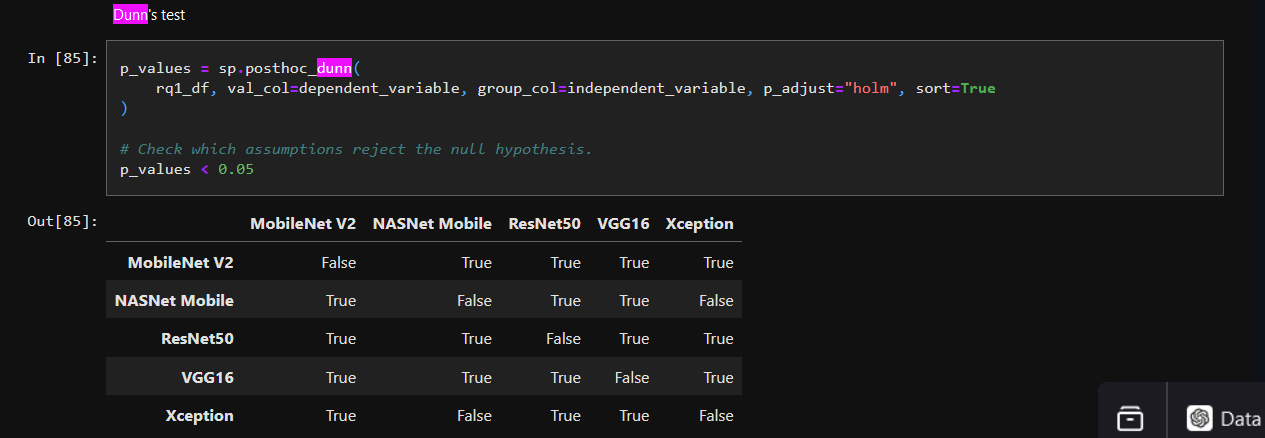


In [157]:
p_values = sp.posthoc_dunn(df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm")

# Check which assumptions reject the null hypothesis.
dunn_results = p_values < 0.05
dunn_results

,cpu_onnx_phi2,cpu_ov_phi2,cpu_torch_phi2,cpu_torchscript_phi2
cpu_onnx_phi2,False,False,False,True
cpu_ov_phi2,False,False,True,False
cpu_torch_phi2,False,True,False,True
cpu_torchscript_phi2,True,False,True,False


In [158]:
#dunn_results.to_csv()

In [159]:
# Check which comparisons reject the null hypothesis
significant_comparisons = p_values < 0.05

# Create a DataFrame to display results with 'X' for significant comparisons
result_display = significant_comparisons.applymap(lambda x: 'X' if x else '')

print("Significance Grid (X indicates a significant difference):")
result_display.to_csv(save_dir+f"dunn_res_{dependent_variable}_{model}.csv")
result_display

Significance Grid (X indicates a significant difference):


,cpu_onnx_phi2,cpu_ov_phi2,cpu_torch_phi2,cpu_torchscript_phi2
cpu_onnx_phi2,,,,X
cpu_ov_phi2,,,X,
cpu_torch_phi2,,X,,X
cpu_torchscript_phi2,X,,X,


## -